# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: session overview

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('../3-Classification/churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [8]:
from sklearn.metrics import accuracy_score

In [9]:
accuracy_score(y_val, churn_decision)

0.801277501774308

In [10]:
accuracy_score(y_val, y_pred >= 0.5)

0.801277501774308

In [11]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.598
0.15 0.664
0.20 0.707
0.25 0.737
0.30 0.759
0.35 0.766
0.40 0.780
0.45 0.793
0.50 0.801
0.55 0.798
0.60 0.797
0.65 0.784
0.70 0.765
0.75 0.744
0.80 0.730
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


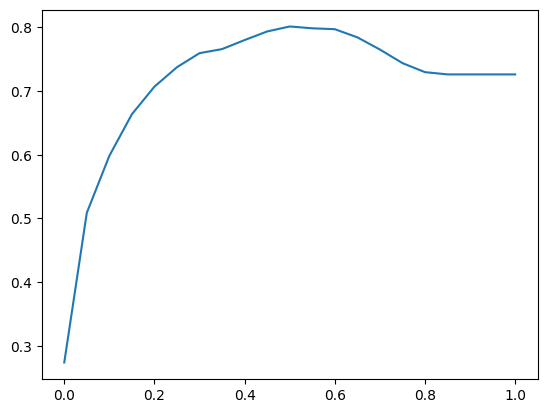

In [12]:
plt.plot(thresholds, scores)

In [13]:
from collections import Counter

In [14]:
Counter(y_pred >=1.0)

Counter({np.False_: 1409})

In [15]:
1 - y_val.mean()

np.float64(0.7260468417317246)

if we predict all as non churning the accuracy will be good   
class imbalance: 3:1   
accuracy for models with class imbalance can be misleading

## 4.3 Confusion Table

* Different types of errors and correct decisions
* Arranging them in a table

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [18]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [19]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [20]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[915, 108],
       [172, 214]])

In [21]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

## 4.4 Precision and recall

precision: How many positive preidctions are correct?   
fraction of positive predictions that are correct   
correctly predicted positive(tp) vs. all predicted positive(tp + fp)

In [22]:
(tp + tn) / (tp + tn + fp + fn)

np.float64(0.801277501774308)

In [23]:
p = tp / (tp + fp)
p

np.float64(0.6645962732919255)

In [24]:
tp + fp

np.int64(322)

Recall : fraction of correctly identified positive examples   
correctly predicted positive(tp) vs. all actual positive(tp + fn)

In [26]:
r = tp / (tp + fn)
r

np.float64(0.5544041450777202)

## 4.5 ROC Curves

roc : receiver operating characteristics

#### TPR and FRP

TPR: fraction of true positives over total number of positives(TP + FN)   
FPR: fraction of false positives over the total number of negative(TN + FP)

In [28]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5544041450777202)

In [30]:
r

np.float64(0.5544041450777202)

In [29]:
fpr = fp / (tn + fp)
fpr

np.float64(0.10557184750733138)

In [37]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [39]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [42]:
df_scores['tpr'] = df_scores.tp/ (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp/ (df_scores.fp + df_scores.tn)

In [44]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,367,547,19,476,0.950777,0.534702
20,0.2,334,361,52,662,0.865285,0.352884
30,0.3,291,244,95,779,0.753886,0.238514
40,0.4,253,177,133,846,0.655440,0.173021
50,0.5,214,108,172,915,0.554404,0.105572
60,0.6,153,53,233,970,0.396373,0.051808
70,0.7,69,14,317,1009,0.178756,0.013685
80,0.8,5,0,381,1023,0.012953,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


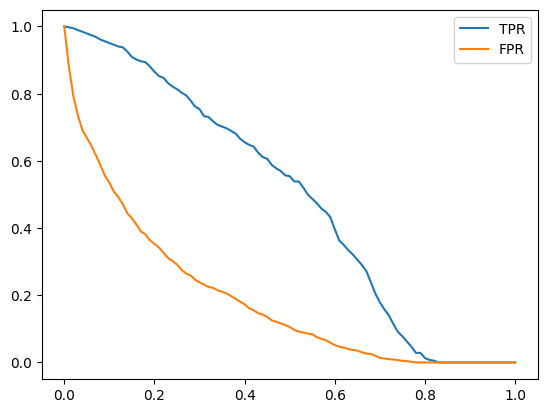

In [47]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

#### Random Model

In [65]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=(len(y_val)))

In [66]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [71]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp/ (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp/ (df_scores.fp + df_scores.tn)

    return df_scores

In [72]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [73]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


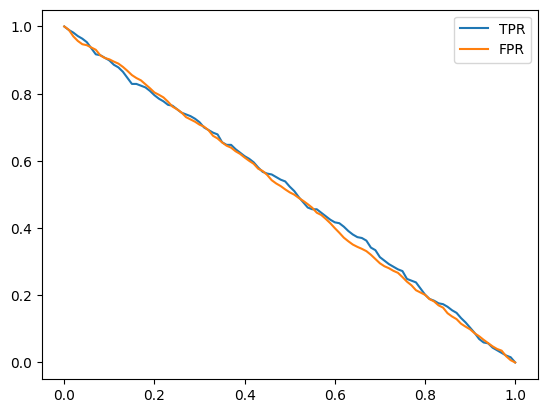

In [74]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()